Importing Librabries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils


Data Preparation

In [2]:
class Edges2ShoesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.files = sorted(os.listdir(root_dir))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path).convert("RGB")

        # split into A (sketch) and B (photo)
        w, h = img.size
        w2 = int(w / 2)
        A = img.crop((0, 0, w2, h))
        B = img.crop((w2, 0, w, h))

        if self.transform:
            A = self.transform(A)
            B = self.transform(B)

        return {"A": A, "B": B}

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# hyperparameters
BATCH_SIZE = 4
IMG_SIZE = 256
LR = 2e-4
EPOCHS = 100

Using device: cuda


In [4]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# paths (update if needed)
train_root = "./edges2shoes/train"
val_root   = "./edges2shoes/val"

train_dataset = Edges2ShoesDataset(train_root, transform=transform)
val_dataset   = Edges2ShoesDataset(val_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train images: {len(train_dataset)}, Val images: {len(val_dataset)}")

Train images: 49825, Val images: 200


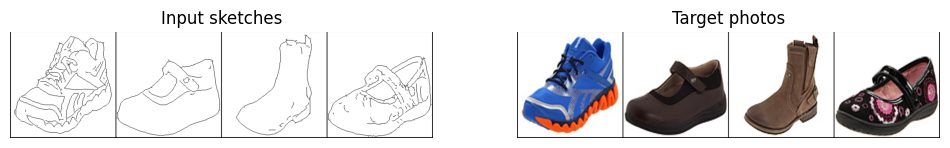

In [5]:
# helper: denormalize image for visualization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# get one batch
batch = next(iter(train_loader))
A = batch["A"][:4]  # sketches
B = batch["B"][:4]  # photos

# create image grids
gridA = vutils.make_grid(denorm(A), nrow=4, padding=2)
gridB = vutils.make_grid(denorm(B), nrow=4, padding=2)

# plot
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Input sketches")
plt.axis("off")
plt.imshow(np.transpose(gridA.cpu().numpy(), (1,2,0)))

plt.subplot(1,2,2)
plt.title("Target photos")
plt.axis("off")
plt.imshow(np.transpose(gridB.cpu().numpy(), (1,2,0)))

plt.show()


Model Initialization

In [ ]:
class UNetBlock(nn.Module):
    """A single U-Net block with optional dropout"""
    def __init__(self, in_ch, out_ch, innermost=False, outermost=False, dropout=False):
        super().__init__()
        if innermost:
            self.model = nn.Sequential(
                nn.LeakyReLU(0.2, True),
                nn.Conv2d(in_ch, out_ch, 4, 2, 1, bias=False),
                nn.ReLU(True),
                nn.ConvTranspose2d(out_ch, in_ch, 4, 2, 1, bias=False),
                nn.BatchNorm2d(in_ch)
            )
        elif outermost:
            self.model = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 4, 2, 1),
                nn.ReLU(True),
                nn.ConvTranspose2d(out_ch*2, out_ch, 4, 2, 1),
                nn.Tanh()
            )
        else:
            layers = [
                nn.LeakyReLU(0.2, True),
                nn.Conv2d(in_ch, out_ch, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(True),
                nn.ConvTranspose2d(out_ch*2, in_ch, 4, 2, 1, bias=False),
                nn.BatchNorm2d(in_ch)
            ]
            if dropout:
                layers.append(nn.Dropout(0.5))
            self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return torch.cat([x, out], 1)  # skip connection


class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, ngf=64):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(in_channels, ngf, 4, 2, 1), nn.LeakyReLU(0.2, True))
        self.enc2 = nn.Sequential(nn.Conv2d(ngf, ngf*2, 4, 2, 1, bias=False), nn.BatchNorm2d(ngf*2), nn.LeakyReLU(0.2, True))
        self.enc3 = nn.Sequential(nn.Conv2d(ngf*2, ngf*4, 4, 2, 1, bias=False), nn.BatchNorm2d(ngf*4), nn.LeakyReLU(0.2, True))
        self.enc4 = nn.Sequential(nn.Conv2d(ngf*4, ngf*8, 4, 2, 1, bias=False), nn.BatchNorm2d(ngf*8), nn.LeakyReLU(0.2, True))
        self.enc5 = nn.Sequential(nn.Conv2d(ngf*8, ngf*8, 4, 2, 1, bias=False), nn.BatchNorm2d(ngf*8), nn.LeakyReLU(0.2, True))
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(ngf*8, ngf*8, 4, 2, 1, bias=False), nn.BatchNorm2d(ngf*8), nn.ReLU(True))
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(ngf*16, ngf*4, 4, 2, 1, bias=False), nn.BatchNorm2d(ngf*4), nn.ReLU(True))
        self.dec3 = nn.Sequential(nn.ConvTranspose2d(ngf*8, ngf*2, 4, 2, 1, bias=False), nn.BatchNorm2d(ngf*2), nn.ReLU(True))
        self.dec4 = nn.Sequential(nn.ConvTranspose2d(ngf*4, ngf, 4, 2, 1, bias=False), nn.BatchNorm2d(ngf), nn.ReLU(True))
        self.dec5 = nn.Sequential(nn.ConvTranspose2d(ngf*2, out_channels, 4, 2, 1), nn.Tanh())

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        d1 = self.dec1(e5)
        d2 = self.dec2(torch.cat([d1, e4], 1))
        d3 = self.dec3(torch.cat([d2, e3], 1))
        d4 = self.dec4(torch.cat([d3, e2], 1))
        d5 = self.dec5(torch.cat([d4, e1], 1))
        return d5


class Discriminator(nn.Module):
    def __init__(self, in_channels=6, ndf=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*4, 1, 4, 1, 1, bias=False)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:

G = Generator().to(device)
D = Discriminator().to(device)

criterion_GAN = nn.BCEWithLogitsLoss().to(device)  # for adversarial loss
criterion_L1  = nn.L1Loss().to(device)            # for pixel-wise loss


optimizer_G = optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))


def real_labels(disc_out):
    return torch.ones_like(disc_out, device=device)

def fake_labels(disc_out):
    return torch.zeros_like(disc_out, device=device)



Training

In [ ]:
import time

# helper to denormalize for saving images
def denorm(x):
    return (x + 1) / 2

# create folders to save generated images
os.makedirs("results/train", exist_ok=True)
os.makedirs("results/val", exist_ok=True)

for epoch in range(1, EPOCHS+1):
    start_time = time.time()
    for i, batch in enumerate(train_loader):
        real_A = batch["A"].to(device)
        real_B = batch["B"].to(device)

        optimizer_D.zero_grad()

        # real
        D_real = D(torch.cat([real_A, real_B], 1))
        loss_D_real = criterion_GAN(D_real, real_labels(D_real))

        # fake
        fake_B = G(real_A)
        D_fake = D(torch.cat([real_A, fake_B.detach()], 1))
        loss_D_fake = criterion_GAN(D_fake, fake_labels(D_fake))

        # total D loss
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        D_fake = D(torch.cat([real_A, fake_B], 1))
        loss_G_GAN  = criterion_GAN(D_fake, real_labels(D_fake))
        loss_G_L1 = criterion_L1(fake_B, real_B) * 100  # L1 weight = 100 as in Pix2Pix
        loss_G = loss_G_GAN + loss_G_L1
        loss_G.backward()
        optimizer_G.step()


        if i % 50 == 0:
            print(f"Epoch [{epoch}/{EPOCHS}] Batch [{i}/{len(train_loader)}] "
                  f"Loss D: {loss_D.item():.4f} Loss G: {loss_G.item():.4f}")


    with torch.no_grad():
        fake_B = G(real_A)
        img_sample = torch.cat((real_A, real_B, fake_B), -1)
        vutils.save_image(denorm(img_sample), f"results/train/epoch_{epoch}.png", nrow=4, padding=2)

    print(f"Epoch [{epoch}/{EPOCHS}] completed in {time.time()-start_time:.1f}s")


Epoch [1/100] Batch [0/12457] Loss D: 0.7220 Loss G: 90.3749
Epoch [1/100] Batch [50/12457] Loss D: 0.6455 Loss G: 44.1596
Epoch [1/100] Batch [100/12457] Loss D: 0.5277 Loss G: 20.3054
Epoch [1/100] Batch [150/12457] Loss D: 0.6423 Loss G: 18.3272
Epoch [1/100] Batch [200/12457] Loss D: 0.7889 Loss G: 25.7921
Epoch [1/100] Batch [250/12457] Loss D: 0.4221 Loss G: 24.1394
Epoch [1/100] Batch [300/12457] Loss D: 0.3958 Loss G: 17.0060
Epoch [1/100] Batch [350/12457] Loss D: 0.4562 Loss G: 19.0259
Epoch [1/100] Batch [400/12457] Loss D: 0.5062 Loss G: 22.7656
Epoch [1/100] Batch [450/12457] Loss D: 0.5142 Loss G: 16.7847
Epoch [1/100] Batch [500/12457] Loss D: 0.6270 Loss G: 12.9631
Epoch [1/100] Batch [550/12457] Loss D: 0.2608 Loss G: 26.6985
Epoch [1/100] Batch [600/12457] Loss D: 0.5551 Loss G: 22.7831
Epoch [1/100] Batch [650/12457] Loss D: 0.2606 Loss G: 32.7007
Epoch [1/100] Batch [700/12457] Loss D: 0.3977 Loss G: 24.0650
Epoch [1/100] Batch [750/12457] Loss D: 0.5972 Loss G: 13.

Testing

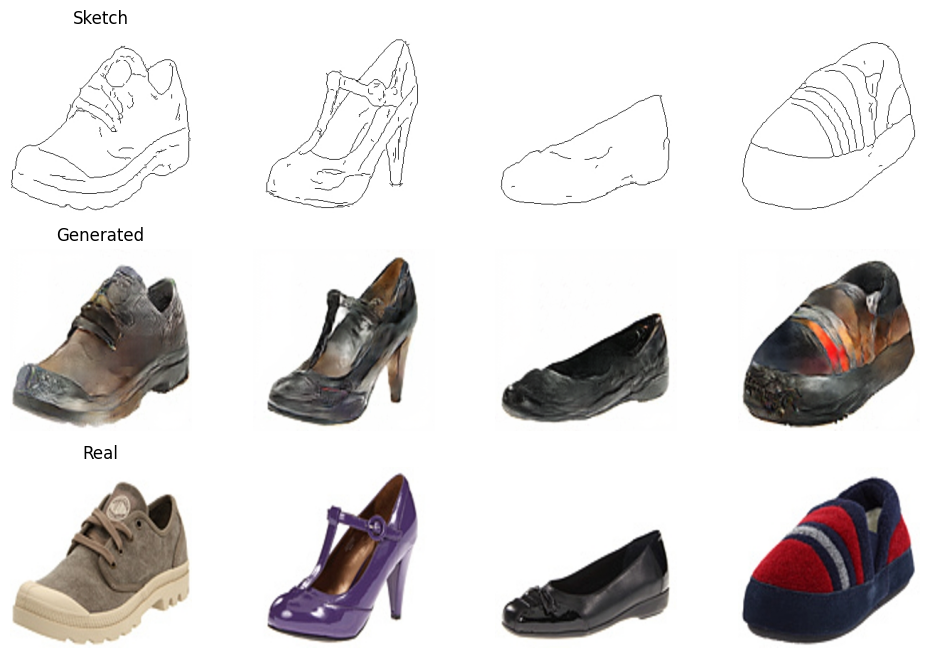

In [15]:
# Test dataset and loader
test_dataset = Edges2ShoesDataset(root_dir="edges2shoes/val", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)


# Switch generator to eval mode
G.eval()

# Take a few test samples
test_batch = next(iter(test_loader))
real_A = test_batch["A"].to(device)[:8]  # first 8 sketches
real_B = test_batch["B"].to(device)[:8]  # first 8 ground-truth photos

# Generate fake images
with torch.no_grad():
    fake_B = G(real_A)

# Visualize results
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

def show_images(sketches, fakes, reals, n=4):
    plt.figure(figsize=(12,8))
    for i in range(n):
        # Sketch
        plt.subplot(3, n, i+1)
        plt.imshow(np.transpose(vutils.make_grid(denorm(sketches[i].unsqueeze(0))).cpu().numpy(), (1,2,0)))
        plt.axis("off")
        if i == 0: plt.title("Sketch")

        # Fake
        plt.subplot(3, n, i+1+n)
        plt.imshow(np.transpose(vutils.make_grid(denorm(fakes[i].unsqueeze(0))).cpu().numpy(), (1,2,0)))
        plt.axis("off")
        if i == 0: plt.title("Generated")

        # Real
        plt.subplot(3, n, i+1+2*n)
        plt.imshow(np.transpose(vutils.make_grid(denorm(reals[i].unsqueeze(0))).cpu().numpy(), (1,2,0)))
        plt.axis("off")
        if i == 0: plt.title("Real")
    plt.show()

show_images(real_A, fake_B, real_B, n=4)
